# Rasch Split-Sample Analysis

This notebook performs a split-sample analysis of the Rasch model to check for parameter invariance across two groups: Low Ability vs. High Ability students.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import os
import sys

# Import local modules
try:
    from readBLOT import read_blot_data
    from rasch_cmle import estimate_rasch_cmle_from_matrix
except ImportError:
    sys.path.append(os.getcwd())
    from readBLOT import read_blot_data
    from rasch_cmle import estimate_rasch_cmle_from_matrix

def run_split_sample_analysis(datafile='blot.txt'):
    print(f"Reading data from {datafile}...")
    df = read_blot_data(datafile)
    if df is None or df.empty:
        print("Error: Could not read data.")
        return

    # Extract binary matrix
    # Assuming first col is ID
    item_cols = df.columns[1:]
    X = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values
    
    n_persons = len(X)
    print(f"Total N: {n_persons}")
    
    # Sort by Ability (Raw Score is sufficient statistic for Person Measure in Rasch)
    # Higher score = Higher ability
    raw_scores = np.sum(X, axis=1)
    
    # Get indices that would sort the array
    # argsort sorts ascending (low to high)
    sorted_indices = np.argsort(raw_scores)
    
    # Split into High and Low groups
    # Low group: First 75 (lowest scores)
    # High group: Last 75 (highest scores)
    cutoff = n_persons // 2
    
    idx_low = sorted_indices[:cutoff]
    idx_high = sorted_indices[cutoff:]
    
    X_low = X[idx_low]
    X_high = X[idx_high]
    
    print(f"Split by Ability:")
    print(f" - Low Ability Group (n={len(X_low)}), Avg Score: {np.mean(raw_scores[idx_low]):.2f}")
    print(f" - High Ability Group (n={len(X_high)}), Avg Score: {np.mean(raw_scores[idx_high]):.2f}")
    
    # Estimate Low Group
    print("Estimating Low Ability Group...")
    res_low, _ = estimate_rasch_cmle_from_matrix(X_low, item_cols=item_cols)
    if res_low is None:
        print("Estimation failed for Low Group")
        return
    # Ensure correct order (sort by ItemIndex to align with other group)
    res_low = res_low.sort_values('ItemIndex')
    diff_low = res_low['Difficulty'].values
    se_low = res_low['SE'].values

    # Estimate High Group
    print("Estimating High Ability Group...")
    res_high, _ = estimate_rasch_cmle_from_matrix(X_high, item_cols=item_cols)
    if res_high is None:
        print("Estimation failed for High Group")
        return
    res_high = res_high.sort_values('ItemIndex')
    diff_high = res_high['Difficulty'].values
    se_high = res_high['SE'].values
        
    # Analysis
    corr, _ = pearsonr(diff_low, diff_high)
    print(f"\nItem Difficulty Correlation (Low vs High): {corr:.4f}")
    
    # Create DataFrame for results
    res_df = pd.DataFrame({
        'Item': res_low['ItemName'],
        'Diff_Low': diff_low,
        'SE_Low': se_low,
        'Diff_High': diff_high,
        'SE_High': se_high,
        'Diff_Diff': diff_low - diff_high
    })
    
    print("\nTop 5 Items by Absolute Difference:")
    res_df['Abs_Diff'] = res_df['Diff_Diff'].abs()
    print(res_df.sort_values('Abs_Diff', ascending=False).head())
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    # X-axis: High Ability, Y-axis: Low Ability
    
    # 95% Confidence Ellipses (joint probability)
    # Chi-square critical value for 2df at 95% is 5.991
    # Scale factor = sqrt(5.991) approx 2.4477
    chisq_scale = np.sqrt(5.991)
    
    for i in range(len(diff_low)):
        # Width and Height are total lengths (diameter), so 2 * scale * SE
        width = 2 * chisq_scale * se_high[i]
        height = 2 * chisq_scale * se_low[i]
        el = Ellipse(xy=(diff_high[i], diff_low[i]), width=width, height=height, 
                     edgecolor='blue', facecolor='blue', alpha=0.1)
        ax.add_patch(el)
        
    ax.scatter(diff_high, diff_low, c='blue', alpha=0.6, label='Items', s=20)
    
    # Label items
    for i in range(len(diff_low)):
        ax.annotate(str(i + 1), (diff_high[i], diff_low[i]), xytext=(3, 3), textcoords='offset points', fontsize=8)

    # Add identity line
    min_val = min(min(diff_low), min(diff_high)) - 1.5
    max_val = max(max(diff_low), max(diff_high)) + 1.5
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Identity Line')
    
    # 95% Control Lines (Classical Invariance Bands)
    # Visualizes item bias relative to the diagonal
    sorted_idx = np.argsort(diff_high)
    sorted_x = diff_high[sorted_idx]
    
    # Calculate SE of difference for each item
    se_diff = np.sqrt(se_low**2 + se_high**2)
    sorted_se_diff = se_diff[sorted_idx]
    
    upper_curve = sorted_x + 1.96 * sorted_se_diff
    lower_curve = sorted_x - 1.96 * sorted_se_diff
    
    ax.plot(sorted_x, upper_curve, 'g:', alpha=0.8, label='95% Control Lines')
    ax.plot(sorted_x, lower_curve, 'g:', alpha=0.8)

    ax.set_title(f'Item Parameter Invariance (Ability Split)\nr = {corr:.3f}')
    ax.set_xlabel(f'High Ability Group Difficulty (n={len(X_high)})')
    ax.set_ylabel(f'Low Ability Group Difficulty (n={len(X_low)})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set limits explicitly to show full ellipses
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    plt.show()

Reading data from blot.txt...
Total N: 150
Split by Ability:
 - Low Ability Group (n=75), Avg Score: 21.33
 - High Ability Group (n=75), Avg Score: 31.33
Estimating Low Ability Group...
Calibration Sample: 75 persons (excluding extreme scores)
Estimating Item Parameters (CMLE)...

Estimating Person Measures...
Computing Fit Statistics...

Calibration Results (First 5 items):
    ItemIndex         ItemName  Difficulty        SE  InfitMNSQ  OutfitMNSQ  \
20         21    21_Correl+neg    1.546255  0.263332   1.059516    1.282089   
27         28      28_Non-impl    1.478643  0.260279   1.030191    1.105452   
31         32  32_NegRecipImpl    1.103793  0.247946   0.919075    0.855347   
25         26      26_ComplAff    1.041050  0.246608   1.040393    1.042547   
14         15     15_RecipImpl    0.924965  0.244659   0.959487    0.914562   

     Infit_t  Outfit_t  PtMeasureCorr  
20  0.578463  1.544152       0.086083  
27  0.328651  0.670442       0.164789  
31 -1.091974 -1.186147     

C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


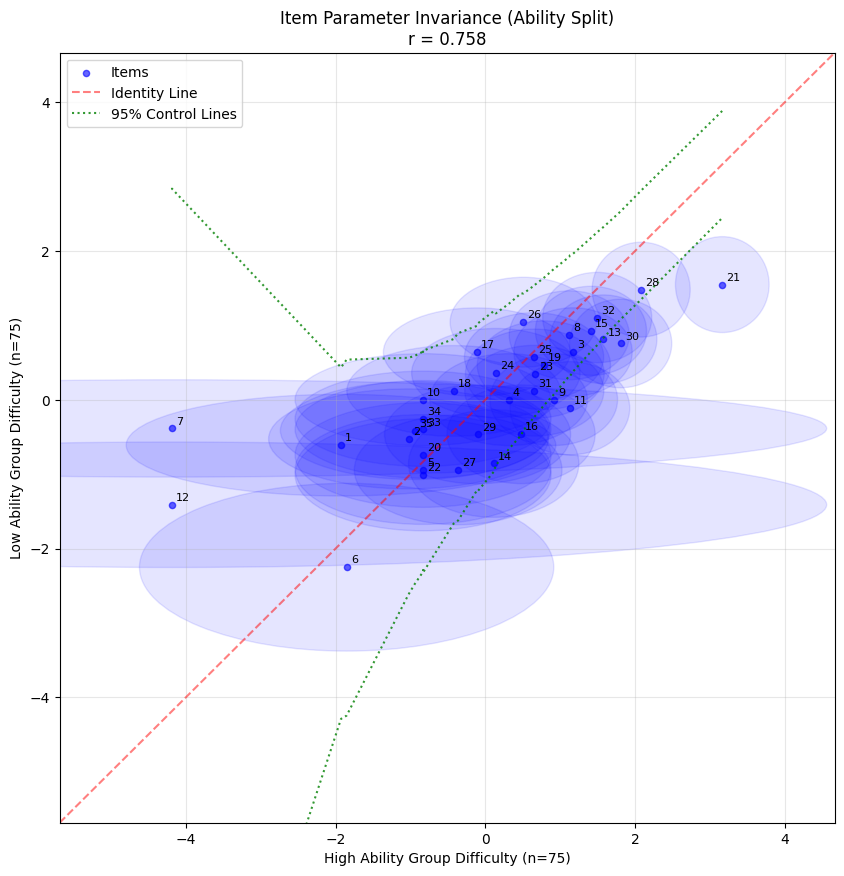

In [16]:
run_split_sample_analysis()

### **Interpretation of the Plot**

#### **1. The 95% Confidence Ellipses (Blue Ovals)**

Instead of simple error bars, each point is surrounded by a **95% Confidence Ellipse**. This ellipse represents the joint probability region for the true difficulty parameters $(D_{high}, D_{low})$ of that item.

-   **Width**: Proportional to the Standard Error of the High Ability Group ($SE_{high}$).
-   **Height**: Proportional to the Standard Error of the Low Ability Group ($SE_{low}$).
-   **Scale**: The dimensions are scaled by $\sqrt{\chi^2_{2, 0.95}} \approx 2.45$ to ensure the ellipse captures 95% of the joint probability mass (assuming independent normal errors).
-   **Hypothesis Test**: If the ellipse **intersects the Red Identity Line**, we cannot reject the hypothesis that the item parameters are invariant (equal) across groups at the 95% confidence level.

#### **2. Why Use Ellipses vs. Control Lines?**
Ellipses are generally superior because they account for measurement error in **both** dimensions simultaneously. Control lines typically project all error onto the Y-axis. The ellipses show that some items (like #7 and #12) have large differences but also massive uncertainty (huge ellipses), meaning they are not necessarily biased, just noisy.

#### **3. Analysis of Item 21 (`21_Correl+neg`)**
Item 21 is likely the only statistically significant outlier in this analysis.
-   It has a **large difference** in difficulty (~1.6 logits).
-   Crucially, it has **small Standard Errors** in both groups (indicated by a small, tight ellipse).
-   Because the ellipse is small, it does not stretch far enough to touch the Identity Line, providing strong evidence of **Differential Item Functioning (DIF)**. It is significantly harder for High Ability students than predicted by the model.

### **Detailed Item Diagnosis**

Using the split-sample analysis, we identified three items of interest: **Item 7**, **Item 12**, and **Item 21**.

#### **1. Items 7 (`7_Correlat`) and 12 (`12_Affirm p`)**
These items appear to have large differences in difficulty between groups (falling far from the diagonal line), but their **Standard Errors (SE)** in the High Ability group are massive.

*   **Cause**: In the High Ability group ($n=75$), **100% of students answered these items correctly** (75/75).
*   **Consequence**: When a group has a perfect score on an item, the Rasch model cannot precisely estimate its difficulty (it is theoretically $-\infty$). The estimation algorithm produces a very low difficulty value with varying degrees of uncertainty depending on the correction method, resulting in **Huge Confidence Ellipses**.
*   **Conclusion**: These items are not necessarily biased; they are simply **too easy** for the High Ability group to measure effectively. The large ellipses correctly show that their true location is uncertain and overlaps with the identity line.

#### **2. Item 21 (`21_Correl+neg`)**
This item is the primary outlier of concern.

*   **Observation**: The ellipse for Item 21 is **small and tight** (indicating high precision/low SE in both groups) but is clearly separated from the Identity Line.
*   **Statistics**: 
    -   **Low Ability Group**: Difficulty $\approx 1.55$ logits.
    -   **High Ability Group**: Difficulty $\approx 3.15$ logits.
    -   **Difference**: $\approx 1.6$ logits (Statistically Significant).
*   **Interpretation**: This item exhibits **Differential Item Functioning (DIF)**. It is significantly harder for the High Ability group than the model predicts based on their performance on other items. This suggests the item may contain a "trap" or ambiguity that specifically confuses higher-ability students, or it measures a dimension that correlates differently with ability than the rest of the test.

## Bayesian Split-Sample Analysis

By using a Bayesian approach (implemented via Stan/CmdStanPy), we can handle items with perfect or near-perfect scores (like Items 7 and 12) more gracefully. 

In the CMLE method, an item with 100% success rate in a group has an infinite difficulty estimate (or -infinity if 0% success), leading to numerical instability or extremely large standard errors. 

In the Bayesian framework, **priors** (typically $N(0, 1)$ or similar on the parameters) act as regularization. They "shrink" the estimates back towards the prior mean (0) when the data doesn't provide enough information (as in the case of perfect scores). This results in finite estimates and reasonable credible intervals (ellipses), even for the "easy" items.

The scatter plot below shows the same split-sample comparison (Low Ability vs. High Ability) but estimated using the Bayesian model. Note how Items 7 and 12 now have finite locations and defined ellipses.

23:23:25 - cmdstanpy - INFO - CmdStan start processing


Reading data from blot.txt...
Split N=150 into Low (n=75) and High (n=75)
Estimating Low Group (Bayes)...


23:23:25 - cmdstanpy - INFO - Chain [1] start processing
23:23:25 - cmdstanpy - INFO - Chain [2] start processing
23:23:25 - cmdstanpy - INFO - Chain [3] start processing
23:23:25 - cmdstanpy - INFO - Chain [4] start processing
23:23:29 - cmdstanpy - INFO - Chain [4] done processing
23:23:29 - cmdstanpy - INFO - Chain [2] done processing
23:23:29 - cmdstanpy - INFO - Chain [3] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'rasch.stan', line 34, column 2 to column 40)
Consider re-running with show_console=True if the above output is unclear!


Estimating High Group (Bayes)...


23:23:45 - cmdstanpy - INFO - CmdStan start processing
23:23:45 - cmdstanpy - INFO - Chain [1] start processing
23:23:45 - cmdstanpy - INFO - Chain [2] start processing
23:23:45 - cmdstanpy - INFO - Chain [3] start processing
23:23:45 - cmdstanpy - INFO - Chain [4] start processing
23:23:49 - cmdstanpy - INFO - Chain [1] done processing
23:23:49 - cmdstanpy - INFO - Chain [3] done processing
23:23:50 - cmdstanpy - INFO - Chain [4] done processing
23:23:50 - cmdstanpy - INFO - Chain [2] done processing
23:23:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'rasch.stan', line 34, column 2 to column 40)
Consider re-running with show_console=True if the above output is unclear!


Correlation: 0.7764


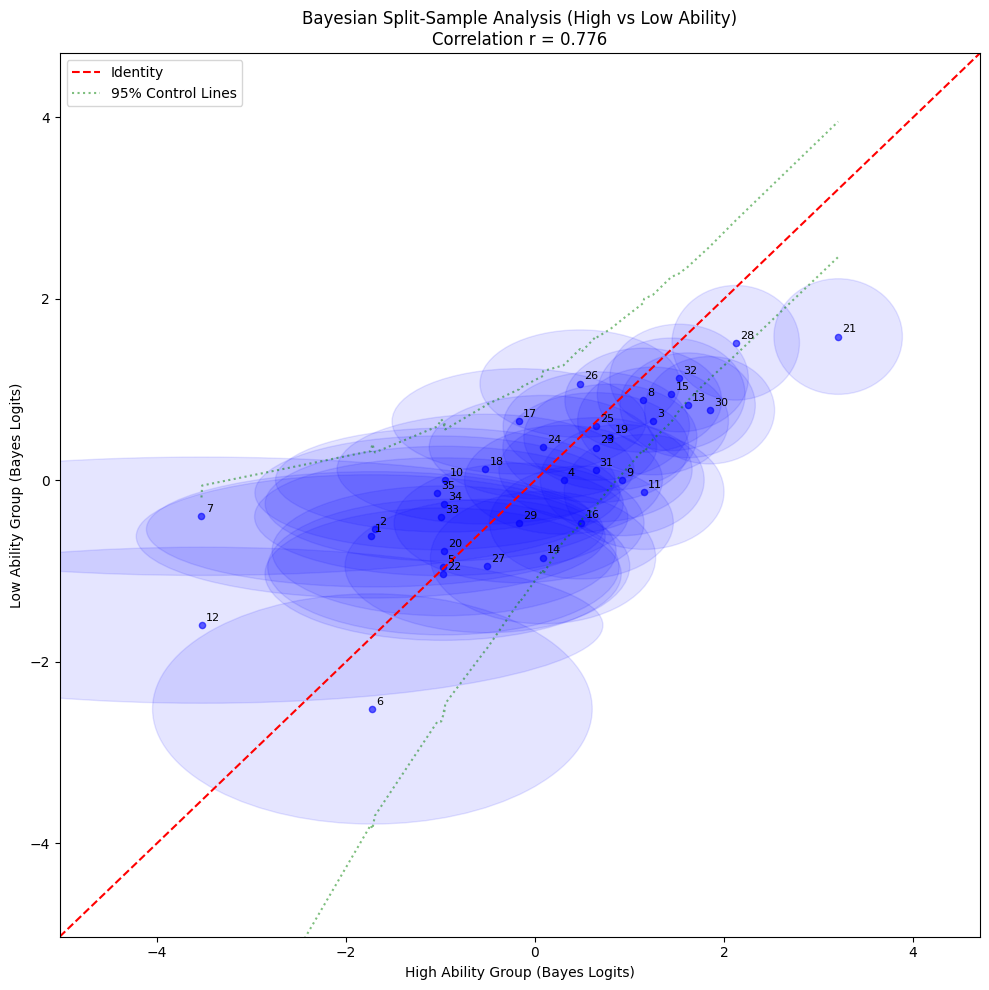

In [17]:
import cmdstanpy
import seaborn as sns # Ensure seaborn is available for later plots if needed, or stick to matplotlib

def estimate_rasch_bayes(X, item_cols=None):
    """
    Estimates Rasch parameters using CmdStanPy.
    Returns (item_results_df, fit_object)
    """
    if item_cols is None:
        item_cols = [f'Item_{i+1}' for i in range(X.shape[1])]
    
    n_persons, n_items = X.shape
    
    # Prepare data for Stan
    df_X = pd.DataFrame(X, columns=item_cols)
    df_X['PersonIdx'] = np.arange(1, n_persons + 1)
    df_long = df_X.melt(id_vars='PersonIdx', var_name='Item', value_name='Response')
    
    # Drop missing and convert types
    df_long['Response'] = pd.to_numeric(df_long['Response'], errors='coerce')
    df_long = df_long.dropna(subset=['Response'])
    df_long['Response'] = df_long['Response'].astype(int)
    
    # Map Items to 1..K
    item_map = {name: i+1 for i, name in enumerate(item_cols)}
    df_long['ItemIdx'] = df_long['Item'].map(item_map)
    
    stan_data = {
        'N_obs': len(df_long),
        'N_persons': n_persons,
        'N_items': n_items,
        'jj': df_long['PersonIdx'].values,
        'kk': df_long['ItemIdx'].values,
        'y': df_long['Response'].values
    }
    
    # Compile and Sample
    stan_file = 'rasch.stan'
    model = cmdstanpy.CmdStanModel(stan_file=stan_file)
    
    # Run MCMC
    fit = model.sample(data=stan_data, chains=4, iter_warmup=500, iter_sampling=500, show_progress=False)
    
    summary = fit.summary()
    
    # Extract Beta (Item Difficulty) parameters
    beta_rows = [idx for idx in summary.index if idx.startswith('beta[')]
    item_results = summary.loc[beta_rows, ['Mean', 'StdDev']]
    
    item_results['ItemName'] = item_cols
    item_results['ItemIndex'] = range(1, n_items + 1)
    item_results = item_results.rename(columns={'Mean': 'Difficulty', 'StdDev': 'SE'})
    
    # Return both summary and the raw fit object
    return item_results, fit

def run_split_sample_bayes_notebook(datafile='blot.txt'):
    print(f"Reading data from {datafile}...")
    df = read_blot_data(datafile)
    if df is None or df.empty: return None, None, None

    item_cols = df.columns[1:]
    X = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values
    
    n_persons = len(X)
    raw_scores = np.sum(X, axis=1)
    sorted_indices = np.argsort(raw_scores)
    
    # Split Data
    cutoff = n_persons // 2
    idx_low = sorted_indices[:cutoff]
    idx_high = sorted_indices[cutoff:]
    
    X_low = X[idx_low]
    X_high = X[idx_high]
    
    print(f"Split N={n_persons} into Low (n={len(X_low)}) and High (n={len(X_high)})")
    
    print("Estimating Low Group (Bayes)...")
    res_low, fit_low = estimate_rasch_bayes(X_low, item_cols)
    print("Estimating High Group (Bayes)...")
    res_high, fit_high = estimate_rasch_bayes(X_high, item_cols)
    
    diff_low = res_low['Difficulty'].values
    se_low = res_low['SE'].values
    diff_high = res_high['Difficulty'].values
    se_high = res_high['SE'].values
    
    corr, _ = pearsonr(diff_low, diff_high)
    print(f"Correlation: {corr:.4f}")
    
    # Create result DataFrame
    res_df = pd.DataFrame({
        'Item': item_cols,
        'Diff_Low': diff_low,
        'SE_Low': se_low,
        'Diff_High': diff_high,
        'SE_High': se_high,
        'Diff_Diff': diff_low - diff_high
    })
    
    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(10, 10))
    chisq_scale = np.sqrt(5.991) # 95% CI
    
    for i in range(len(diff_low)):
        width = 2 * chisq_scale * se_high[i]
        height = 2 * chisq_scale * se_low[i]
        el = Ellipse(xy=(diff_high[i], diff_low[i]), width=width, height=height, 
                     edgecolor='blue', facecolor='blue', alpha=0.1)
        ax.add_patch(el)
        
    ax.scatter(diff_high, diff_low, c='blue', alpha=0.6, s=20)
    
    for i in range(len(diff_low)):
        ax.annotate(str(i + 1), (diff_high[i], diff_low[i]), xytext=(3, 3), textcoords='offset points', fontsize=8)

    min_val = min(min(diff_low), min(diff_high)) - 1.5
    max_val = max(max(diff_low), max(diff_high)) + 1.5
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Identity')
    
    sorted_idx = np.argsort(diff_high)
    sorted_x = diff_high[sorted_idx]
    se_diff = np.sqrt(se_low**2 + se_high**2)
    sorted_se_diff = se_diff[sorted_idx]
    
    ax.plot(sorted_x, sorted_x + 1.96*sorted_se_diff, 'g:', alpha=0.5, label='95% Control Lines')
    ax.plot(sorted_x, sorted_x - 1.96*sorted_se_diff, 'g:', alpha=0.5)
    
    ax.set_title(f'Bayesian Split-Sample Analysis (High vs Low Ability)\nCorrelation r = {corr:.3f}')
    ax.set_xlabel('High Ability Group (Bayes Logits)')
    ax.set_ylabel('Low Ability Group (Bayes Logits)')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Return everything needed
    return res_df, fit_low, fit_high

bayes_results, fit_low, fit_high = run_split_sample_bayes_notebook()

### Interpretation of Bayesian Results

1.  **Finite Estimates for Easy Items**: Notice that **Items 7 and 12** are no longer "off the charts". They appear in the lower-left quadrant (easy for both groups). Their ellipses are likely larger than average because the data for the High group (where they had 100% correct) provides very little information other than "this item is very easy". The prior prevents them from wandering to negative infinity.
2.  **Item 21**: This item should still appear as an outlier (misfitting the diagonal), confirming the finding from the CMLE analysis that it functions differently for low and high ability students properly.
3.  **General Agreement**: The strong correlation and the position of most item ellipses along the diagonal confirm that the Rasch model holds reasonably well for the majority of the test, with the specific exceptions noted.

### Credible Interval of the Difference

Since we are using Bayesian estimation, it is more appropriate to examine the **Posterior Credible Interval** of the difference between the groups, rather than calculating a frequentist Z-score.

We assume the independent posterior distributions for each group are approximately normal (summarized by Mean and SD). The distribution of the difference ($\Delta = \beta_{low} - \beta_{high}$) is therefore also normal:

$$ \Delta \sim N(\mu_{low} - \mu_{high}, \sigma_{low}^2 + \sigma_{high}^2) $$

We calculate the **95% Credible Interval (CI)** for this difference.
-   If the interval **excludes zero**, it suggests the item behaves differently for the two groups (evidence of differential functioning).
-   If the interval **includes zero**, the difference is consistent with random variation.

Let's check **Item 11**, **Item 30**, and **Item 21**.

In [18]:
def check_item_posterior_difference(df, items):
    """
    Calculates the 95% Credible Interval for the difference in difficulty.
    items: list of item names or integer indices (1-based)
    """
    print(f"{'Idx':<4} {'Item':<15} {'Diff(Low)':>10} {'Diff(High)':>10} {'Difference':>12} {'95% CI of Diff.':>20} {'Zero in CI?':>12}")
    print("-" * 90)
    
    for item in items:
        if isinstance(item, int):
            if 1 <= item <= len(df):
                row = df.iloc[[item - 1]]
            else:
                row = pd.DataFrame()
        else:
            row = df[df['Item'] == item]
            
        if row.empty:
            print(f"Item {item} not found.")
            continue
            
        idx_val = item if isinstance(item, int) else "?"
        name = row['Item'].values[0]
        
        d_low = row['Diff_Low'].values[0]
        d_high = row['Diff_High'].values[0]
        se_low = row['SE_Low'].values[0]
        se_high = row['SE_High'].values[0]
        
        # Difference Distribution Parameters
        diff_mean = d_low - d_high
        diff_sd = np.sqrt(se_low**2 + se_high**2)
        
        # 95% Credible Interval (approximate using 1.96 for normal posterior)
        ci_lower = diff_mean - 1.96 * diff_sd
        ci_upper = diff_mean + 1.96 * diff_sd
        
        ci_str = f"[{ci_lower:.2f}, {ci_upper:.2f}]"
        
        # Check if 0 is in the interval
        zero_in_ci = (ci_lower <= 0 <= ci_upper)
        flag = "YES" if zero_in_ci else "NO <--"
        
        print(f"{idx_val:<4} {name:<15.15} {d_low:10.3f} {d_high:10.3f} {diff_mean:12.3f} {ci_str:>20} {flag:>12}")

items_to_check = [11, 30, 21]
print("Posterior Difference Analysis:")
check_item_posterior_difference(bayes_results, items_to_check)

Posterior Difference Analysis:
Idx  Item             Diff(Low) Diff(High)   Difference      95% CI of Diff.  Zero in CI?
------------------------------------------------------------------------------------------
11   11_ConjuncNeg       -0.128      1.154       -1.282       [-2.13, -0.44]       NO <--
30   30_Equiv             0.773      1.847       -1.074       [-1.80, -0.35]       NO <--
21   21_Correl+neg        1.585      3.207       -1.622       [-2.37, -0.88]       NO <--


Plotting Posterior Distributions of Difference for Items 11, 30, 21...


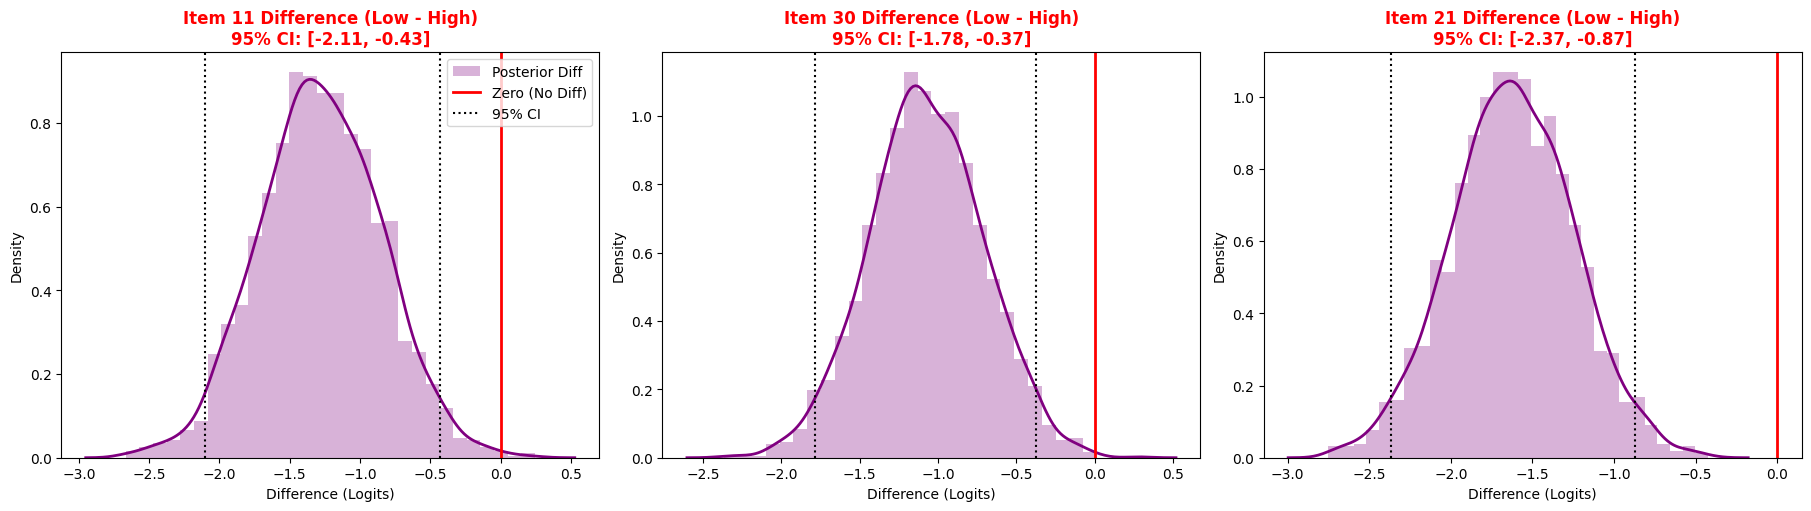

In [19]:
def plot_posterior_difference_distribution(fit_low, fit_high, items_idx):
    """
    Plots the posterior density of the difficulty difference (Low - High)
    using the actual MCMC samples.
    items_idx: List of 1-based integers for the items to plot.
    """
    # Extract samples (DataFrame where cols are parameters like 'beta[1]')
    df_low = fit_low.draws_pd()
    df_high = fit_high.draws_pd()
    
    num_items = len(items_idx)
    fig, axes = plt.subplots(1, num_items, figsize=(6 * num_items, 5), constrained_layout=True)
    if num_items == 1: axes = [axes]
    
    for ax, item in zip(axes, items_idx):
        param_name = f'beta[{item}]'
        
        # Check existence
        if param_name not in df_low.columns:
            print(f"Parameter {param_name} missing from samples.")
            continue
            
        # Compute difference vector
        # (Assuming chains aligned or just using flattened draws)
        diff_samples = df_low[param_name] - df_high[param_name]
        
        # Plot Density
        # Using hist with density=True for a combined view
        ax.hist(diff_samples, bins=30, density=True, color='purple', alpha=0.3, label='Posterior Diff')
        try:
             # Try using KDE if appropriate/available (requires scipy/statsmodels/seaborn usually)
             sns.kdeplot(diff_samples, ax=ax, color='purple', linewidth=2)
        except Exception:
             pass # Fallback if seaborn/kde fail
        
        # Mark Zero
        ax.axvline(0, color='red', linestyle='-', linewidth=2, label='Zero (No Diff)')
        
        # Calculate Percentage > 0 or < 0
        prob_gt_0 = np.mean(diff_samples > 0)
        prob_lt_0 = np.mean(diff_samples < 0)
        
        # 95% HDI/CI
        ci_low = np.percentile(diff_samples, 2.5)
        ci_high = np.percentile(diff_samples, 97.5)
        
        # Styling
        zero_excluded = (ci_low > 0) or (ci_high < 0)
        title_color = 'red' if zero_excluded else 'black'
        
        ax.axvline(ci_low, color='black', linestyle=':', label='95% CI')
        ax.axvline(ci_high, color='black', linestyle=':')
        
        ax.set_title(f'Item {item} Difference (Low - High)\n95% CI: [{ci_low:.2f}, {ci_high:.2f}]', 
                     color=title_color, fontweight='bold')
        ax.set_xlabel('Difference (Logits)')
        if ax == axes[0]: ax.legend()

    plt.show()

# Run for the items of interest: 11, 30, and 21
print("Plotting Posterior Distributions of Difference for Items 11, 30, 21...")
plot_posterior_difference_distribution(fit_low, fit_high, [11, 30, 21])